# Lets place this notebook in the root directory

In [1]:
import os
path = %pwd
if path.split(os.sep)[-1] == 'notebooks':
    %cd ..

/mnt/c/Users/Mustapha/Documents/competitions/klee_project_audio


Lets also refresh all our dependecies in run time

In [2]:
%reload_ext autoreload
%autoreload 2

load environment variables, if they exist

In [3]:
from dotenv import load_dotenv

load_dotenv(".env_consts")

True

# Imports

In [4]:
# -------------------------------- torch stuff ------------------------------- #
import torch

# ----------------------------------- other ---------------------------------- #
from tqdm import tqdm
import wandb

# ---------------------------------- Custom ---------------------------------- #
from src.load_dataset_fft_aug import get_splitter_dataloaders_fft

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Get data

In [96]:
F16 = torch.float16
F32 = torch.float32
F64 = torch.float64
FTYPE = F32
TRAIN_SPLIT = float(os.getenv('KLEE_TRAIN_SPLIT', 0.8))
BATCH_SIZE = int(os.getenv('KLEE_BATCH_SIZE', 64))
kwargs = {
        "BATCH_SIZE": BATCH_SIZE,
        "TRAIN_SPLIT": TRAIN_SPLIT,
        "FTYPE": FTYPE,
        "fft_nperseg": 400,
        "fft_noverlap": 240,
        "fft_window_type": "tukey",
        "fft_in_db": False,
        "max_random_frequency_roll": 1,
        "random_time_roll": True,
        "noise_attenuation": 0.1,
        }

print("kwargs : ",kwargs)
train_loader, val_loader, data = get_splitter_dataloaders_fft(**kwargs)

kwargs :  {'BATCH_SIZE': 8, 'TRAIN_SPLIT': 0.8, 'FTYPE': torch.float32, 'fft_nperseg': 400, 'fft_noverlap': 240, 'fft_window_type': 'tukey', 'fft_in_db': False, 'max_random_frequency_roll': 1, 'random_time_roll': True, 'noise_attenuation': 0.1}


Caching dataset: 100%|██████████| 2/2 [00:00<00:00, 43.29it/s]


### debug

858.5184
target :  tensor([0, 0])


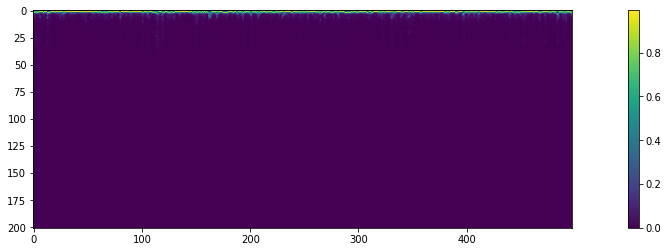

In [115]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy
# data.add_noise = True
fft, target = data[1]
# print("norm", np.linalg.norm(fft, axis=0, keepdims=True))
# fft /= np.linalg.norm(fft, axis=1, keepdims=True) + 1e-8
print(fft.sum())
print("target : ",target)
plt.figure(figsize=(20, 4))
plt.imshow(fft)
plt.colorbar()
plt.show()

In [116]:
import soundfile as sf
from utils.vscode_audio import Audio

time, clip = scipy.signal.istft(fft, fs=16000, nperseg=kwargs["fft_nperseg"], noverlap=kwargs["fft_noverlap"], window=kwargs["fft_window_type"])
print(len(time))
Audio(clip, 16000)

79520


[tensor([[[5.5234e-01, 6.1750e-01, 1.2011e-01,  ..., 9.5544e-01,
          6.6230e-01, 5.4188e-02],
         [8.2933e-01, 7.8295e-01, 9.5074e-01,  ..., 2.7436e-01,
          7.3741e-01, 9.9037e-01],
         [3.8836e-02, 6.7161e-02, 2.7448e-01,  ..., 9.3803e-02,
          1.8191e-02, 8.5286e-02],
         ...,
         [6.3749e-08, 2.0042e-08, 1.1565e-08,  ..., 7.3847e-09,
          1.2267e-08, 2.1613e-08],
         [1.0168e-09, 3.3858e-09, 6.3019e-09,  ..., 2.1543e-09,
          4.5100e-09, 1.5823e-08],
         [3.5644e-03, 8.3935e-03, 2.3532e-02,  ..., 3.5366e-02,
          9.9379e-03, 2.3352e-04]]]), tensor([[0, 0]])]
torch.Size([1, 201, 498])


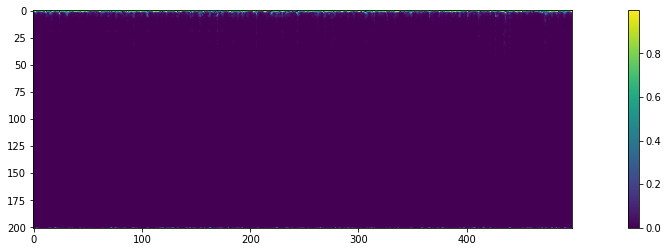

In [119]:
for d in train_loader:
    print(d)
    fft = d[0]
    plt.figure(figsize=(20, 4))
    print(fft.shape)
    plt.imshow(fft[0])
    plt.colorbar()
    plt.show()
    break

# Randomness propagates also with datalaloaders and data splitters (y)

[tensor([[[1.1642e-01, 1.3668e-01, 9.2528e-02,  ..., 1.6506e-01,
          3.9891e-03, 2.5695e-02],
         [9.0253e-01, 7.0806e-01, 5.5150e-01,  ..., 6.5914e-01,
          3.0586e-01, 1.2595e-01],
         [2.0149e-01, 4.7914e-01, 5.9000e-01,  ..., 1.9856e-01,
          8.8064e-01, 9.6588e-01],
         ...,
         [1.8259e-07, 1.1307e-06, 1.1929e-06,  ..., 2.7999e-06,
          1.1332e-05, 1.3552e-06],
         [9.3522e-08, 2.4644e-07, 5.4790e-07,  ..., 2.0248e-05,
          5.8994e-06, 6.1020e-07],
         [2.0326e-08, 1.0872e-07, 1.9244e-07,  ..., 2.4280e-07,
          1.4105e-06, 5.8165e-11]]]), tensor([[0, 0]])]
torch.Size([1, 201, 498])


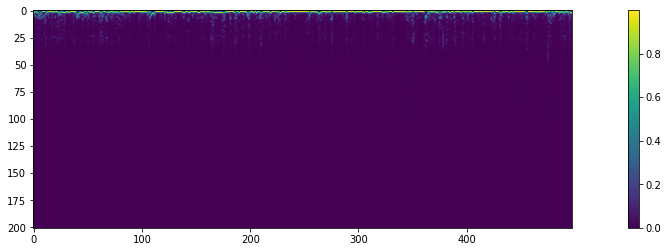

In [123]:
for d in val_loader:
    print(d)
    fft = d[0]
    plt.figure(figsize=(20, 4))
    print(fft.shape)
    plt.imshow(fft[0])
    plt.colorbar()
    plt.show()
    break

# Dataset properties could be changed after data splitter to remove randomness (y)

In [10]:
example, lab = train_loader.dataset[0]
example.shape  # (frequency, time)

torch.Size([201, 498])

# WandB

In [7]:
wandb.init(project="klee_project_audio_2", entity="mustapha")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mustapha (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Original model CRNN and FCRNN

### Create model

In [7]:
class FCRNNPermuteForLSTM(torch.nn.Module):
    """
    Permute the input from (batch, channel, time) to (batch, time, channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.permute(0, 2, 1)
    
class PermuteForLSTM(torch.nn.Module):
    """
    Permute the input from (batch, channel, freq, time) to (batch, time, freq, channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.permute(0, 3, 2, 1)

class ReshapForLSTM(torch.nn.Module):
    """
    Reshape the input from (batch, time, freq, channel) to (batch, time, freq*channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(x.shape[0], x.shape[1], -1)

class SequentialLSTM(torch.nn.Module):
    """
    LSTMs in Pytorch, outputs a tuple (output, (h_n, c_n)), we only need output
    """
    def __init__(self, input_size=1280, hidden_size=40, num_layers=1, dropout=0):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
    def forward(self, x):
        x, _ = self.lstm(x)
        return x

In [9]:
# torch sequential
class Parameters():
    def __init__(self, parameters):
        self.__dict__.update(parameters)

def FCRNN(p):
    model = torch.nn.Sequential( #input size = 80000
        torch.nn.Conv1d(201, p.c_1, kernel_size=p.k_1),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=p.mxp_1, stride=p.mxp_1),
        
        torch.nn.Conv1d(p.c_1, p.c_2, kernel_size=p.k_2),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=p.mxp_2, stride=p.mxp_2),
        
        torch.nn.Conv1d(p.c_2, p.c_3, kernel_size=p.k_3),
        torch.nn.ReLU(),
        torch.nn.Dropout(p.dropout),
        
        FCRNNPermuteForLSTM(),
        SequentialLSTM(input_size=p.c_3, hidden_size=p.h),
        torch.nn.Tanh(),
        
        torch.nn.MaxPool1d(kernel_size=p.mxp, stride=p.mxp),
        torch.nn.Flatten(),
        # torch.nn.Linear(59*20, 2) 
    )
    input_features = model(torch.randn(1, 201, 498)).shape[1]
    # print("input_features : ",input_features)
    model.add_module("fc", torch.nn.Linear(input_features, 2))
    return model
        
def CRNN(p):
    return torch.nn.Sequential( #input size = 80000
        torch.nn.Conv2d(1, 64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 32, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=3),
        
        torch.nn.Conv2d(32, 128, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(128, 64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=3),
        
        torch.nn.Dropout(p.dropout),
        #permute 3 with 1
        PermuteForLSTM(),
        ReshapForLSTM(),
        SequentialLSTM(1280, 40), # 1280 = 20 freq *64 channels
        torch.nn.Tanh(),
        torch.nn.MaxPool1d(kernel_size=2, stride=2),
        
        
#         torch.nn.Conv2d(64, 64, kernel_size=5, stride=5),
#         torch.nn.ReLU(),
        
        
        torch.nn.Flatten(),
        torch.nn.Linear(53*20, 11), # Original contains 52*20, I don't know why !
        torch.nn.Softmax(dim=1)        
        
#         torch.nn.Linear(2560, 11), # Original contains 52*20, I don't know why !
#         torch.nn.Softmax(dim=1)
    )

params = Parameters({
    "dropout": 0.2,
    "c_1": 32,
    "k_1": 3,
    "mxp_1": 4,
    
    "c_2": 64,
    "k_2": 3,
    "mxp_2": 2,
    
    "c_3": 64,
    "k_3": 3,
    
    "h": 40,
    "mxp": 2,
    
})
model = FCRNN(params)

In [10]:
example, target = train_loader.dataset[0]
print("example_shape",example.shape)
print("target shape", target.shape)
model(example.unsqueeze(0)).shape

example_shape torch.Size([201, 498])
target shape torch.Size([2])


torch.Size([1, 2])

### Train model

In [11]:
LEARNING_RATE = 2e-3
EPOCHS = 200
EVAL_EACH = 10
config = {
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "MODEL" : "F-RCNN",
    "MODEL_PARAMS" : params,
    "OPTIMIZER": "ADAM",
    # "batch_size": BATCH_SIZE,
    **kwargs
}
wandb.config.update(config)

In [12]:

def train_loop(LEARNING_RATE = LEARNING_RATE, 
            EPOCHS = EPOCHS,
            EVAL_EACH = EVAL_EACH,
            params = params,
            train_loader = train_loader,
            val_loader = val_loader,
            wandb = wandb,
            **kwargs):
    model = FCRNN(params).to("cuda")
    loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        # -------------------------------- Train loop -------------------------------- #
        train_mean_loss = 0
        train_mean_count_loss = 0
        for d in tqdm(train_loader, "training loop"):
            audios = d[0].to("cuda")
            labels = d[1].to("cuda")
            
            predictions = model.forward(audios)
            # gender loss
            loss_value = loss(predictions, labels)
            train_mean_loss += loss_value.item()
            # count loss
            count_loss_value = loss(predictions.sum(axis=1), labels.sum(axis=1))
            train_mean_count_loss += count_loss_value.item()
            # total loss
            total_loss = loss_value + count_loss_value
            #optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
        print("Epoch {}/{}".format(epoch+1, EPOCHS))
        print("Train gender Loss : {:.4f}".format(train_mean_loss/len(train_loader)))
        print("Train count Loss : {:.4f}".format(train_mean_count_loss/len(train_loader)))
        log = {
            "MAE_train_gender_loss":train_mean_loss/len(train_loader),
            "MAE_train_count_loss":train_mean_count_loss/len(train_loader),
            "epoch":epoch
            }
        # --------------------------------- Eval loop -------------------------------- #
        if (epoch+1)%EVAL_EACH == 0:
            val_mean_loss = 0
            val_mean_count_loss = 0
            model.eval() # No more dropouts
            for d in tqdm(val_loader, "evaluation loop"):
                audios = d[0].to("cuda")
                labels = d[1].to("cuda")
                
                predictions = model.forward(audios)
                # gender loss
                loss_value = loss(predictions, labels)
                val_mean_loss += loss_value.item()
                # count loss
                count_loss_value = loss(predictions.sum(axis=1), labels.sum(axis=1))
                val_mean_count_loss += count_loss_value.item()
            model.train() # Reactivate dropouts
            log["MAE_val_gender_loss"] = val_mean_loss/len(val_loader)
            log["MAE_val_count_loss"] = val_mean_count_loss/len(val_loader)
            print("validation gender Loss : {:.4f}".format(val_mean_loss/len(val_loader)))
            print("validation count Loss : {:.4f}".format(val_mean_count_loss/len(val_loader)))
        wandb.log(log)
    return model
# train_loop()

### Prediction

In [10]:
example, lab = val_loader.dataset[14]
example = example.unsqueeze(0)
print("label", lab)
print("input_shape", example.shape)
example = example.to("cuda")
model(example)  # (frequency, time)

label tensor([0, 2])
input_shape torch.Size([1, 201, 498])


NameError: name 'model' is not defined

In [30]:
%mkdir -p custom_models
torch.save(model, "custom_models/F-CRNN_mae_49_58.pth")

In [9]:
model_loaded = torch.load("custom_models/F-CRNN_mae_49_58.pth")

In [17]:
example, lab = val_loader.dataset[79]
example = example.unsqueeze(0)
print("label", lab)
print("input_shape", example.shape)
example = example.to("cuda")
model_loaded(example)  # (frequency, time)

label tensor([5, 3])
input_shape torch.Size([1, 201, 498])


tensor([[4.2245, 3.8370]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Wandb Sweeps

In [13]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
            
        new_kwargs = kwargs.copy()
        new_kwargs.update(config)
        train_loader, val_loader, data = get_splitter_dataloaders_fft(**new_kwargs)
        
        params = Parameters(config)
        
        train_loop(LEARNING_RATE = config.learning_rate,
                    EPOCHS = config.epochs,
                    EVAL_EACH = config.eval_each,
                    params = params,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    wandb = wandb,
                )

In [14]:
sweep_config = {
    "name": "F-CRNN_hyperparam_search",
    "method": "bayes",
    "metric": {
        "name": "MAE_val_gender_loss"
    },
    "parameters": {
        "eval_each": {
            "value": 1
        },
        "epochs": {
            "values": [30, 50, 70, 100]
        },
        "optimizer": {
            "value": "Adam"  
        },
        "learning_rate": {
            'distribution': 'uniform',
            "min": 5e-5,
            "max": 5e-3
        },
        "noise_attenuation": {
            "values": [0.05, 0.1, 0.2, 0.5, 0.8]
        },
        "max_random_frequency": {
            "values": [1, 2, 3]
        },
        "fft_in_db": {
            "values": [True, False]
        },
        "BATCH_SIZE": {
            "values": [32, 64, 128]
        },
        
        "dropout": {
            "values": [0.1, 0.3, 0.5]
        },
        "c_1": {
            "values": [16, 32, 64, 128]
        },
        "k_1": {
            "values": [3, 5, 7]
        },
        "mxp_1": {
            "values": [2, 4, 6]
        },

        "c_2": {
            "values": [16, 32, 64, 128]
        },
        "k_2": {
            "values": [3, 5, 7]
        },
        "mxp_2": {
            "values": [2, 4, 6]
        },

        "c_3": {
            "values": [16, 32, 64, 128]
        },
        "k_3": {
            "values": [3, 5, 7]
        },

        "h": {
            "values": [20, 30, 40, 50, 60, 80]
        },
        "mxp": {
            "values": [2, 4, 6]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="klee_project_audio_2")


Create sweep with ID: m7led257
Sweep URL: https://wandb.ai/mustapha/klee_project_audio_2/sweeps/m7led257


In [52]:
wandb.agent(sweep_id, train, count=100)

wandb: Agent Starting Run: zqdyxudc with config:
wandb: 	BATCH_SIZE: 128
wandb: 	c_1: 128
wandb: 	c_2: 32
wandb: 	c_3: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	eval_each: 1
wandb: 	fft_in_db: True
wandb: 	h: 80
wandb: 	k_1: 3
wandb: 	k_2: 5
wandb: 	k_3: 5
wandb: 	learning_rate: 0.0005528932113175912
wandb: 	max_random_frequency: 1
wandb: 	mxp: 4
wandb: 	mxp_1: 2
wandb: 	mxp_2: 6
wandb: 	noise_attenuation: 0.05
wandb: 	optimizer: Adam
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Caching dataset:  34%|███▍      | 1943/5720 [00:32<00:57, 65.21it/s]